# Feature Importance with SHAP values

In [2]:
# Imports
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.inspection import permutation_importance
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import shap

## Step 0 -- Data Exploration & Preprocessing (copy)

In [5]:
# Penguin dataset
data_penguins = sns.load_dataset("penguins").dropna()
X_penguins = data_penguins.drop(columns="species")
y_penguins = data_penguins["species"]
X_penguins = pd.get_dummies(X_penguins) # one-hot encode categorical features

# Student performance dataset
data_students = fetch_ucirepo(id=320) 
X_students = data_students.data.features 
Y_students = data_students.data.targets 
X_students = pd.get_dummies(X_students) # one-hot encode categorical features

# Digits dataset
data_digits = load_digits()
X_digits = data_digits.data
y_digits = data_digits.target

# Step 2 -- Feature Importance with SHAP values

SHAP (SHapley Additive exPlanations) is a unified framework for interpreting model predictions.  
It assigns each feature an importance value for a given prediction based on ideas from cooperative game theory.

Key Ideas:
- Each feature is viewed as a "player" in a game.
- The "payout" is the model's prediction.
- SHAP computes how much each feature contributes to the prediction, fairly, by averaging over all possible feature combinations.

Why SHAP?
- Works for both classification and regression.
- Offers **global** (feature-level) and **local** (instance-level) explanations.
- The TreeExplainer variant is efficient for tree-based models (like Random Forests).


#### Penguins

In [6]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_penguins, y_penguins, random_state=42)

# Fit model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [7]:
# SHAP explainer
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

## Step 2.1: Overall feature importance

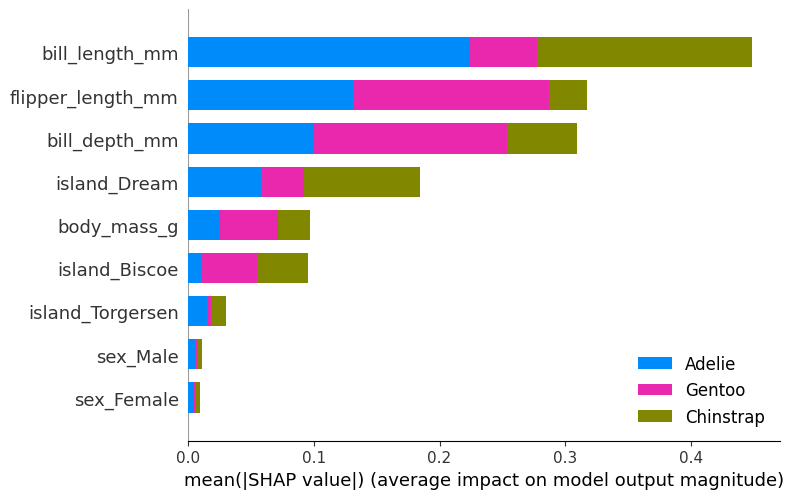

In [19]:
# create summary plot for overall feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar", class_names=clf.classes_)

<div style="border: 1px solid rgb(0, 0, 0); background-color:rgb(224, 179, 83); padding: 10px; border-radius: 5px; color: white;">
<b>❓ Question:</b> How can we interpret these results?
</div>

<details>
<summary>💬 Click to show explanation</summary>

<div style="border: 1px solid #007acc; background-color: #e6f2ff; padding: 10px; border-radius: 5px; color: black;">
<b>📊 How to Interpret the SHAP Bar Plot (Multiclass Case)</b>

The SHAP bar plot shows the <b>average absolute contribution</b> of each feature to the model's prediction probabilities — separately for each class.

Since our task is multiclass classification with <b>mutually exclusive classes</b> (only one class can be correct), increasing the predicted probability for one class necessarily <b>reduces it for the others</b>.

- Each bar represents a feature’s importance in <b>pushing the model toward a specific class</b>.
- A longer bar for a class means that feature often helped the model decide <b>in favor of that class</b>.
- Because the probabilities are interdependent, a feature important for one class is implicitly important <b>against others</b>.

Use this plot to answer:  
<b>“Which features most strongly influence the model to predict a given class — rather than the others?” "Which features are the most important overall?"</b>
</div>

</details>

## Step 2.2: Beeswarm plots: Directional feature importance

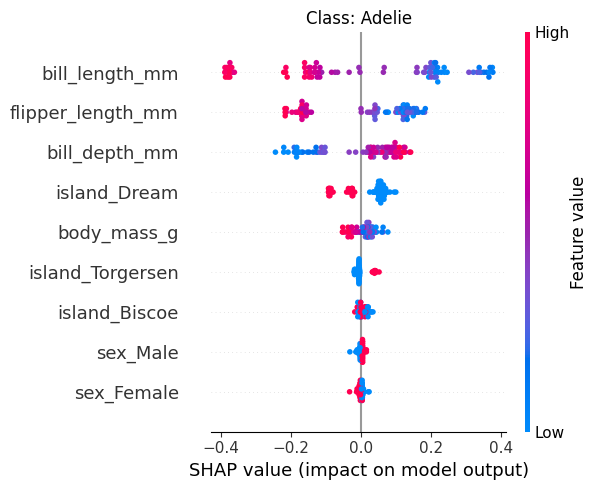

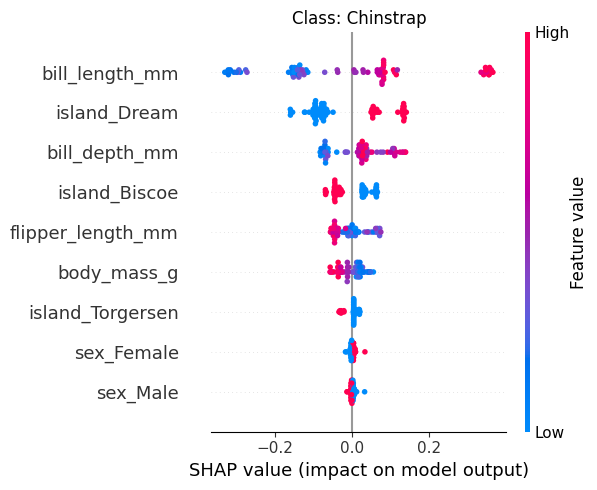

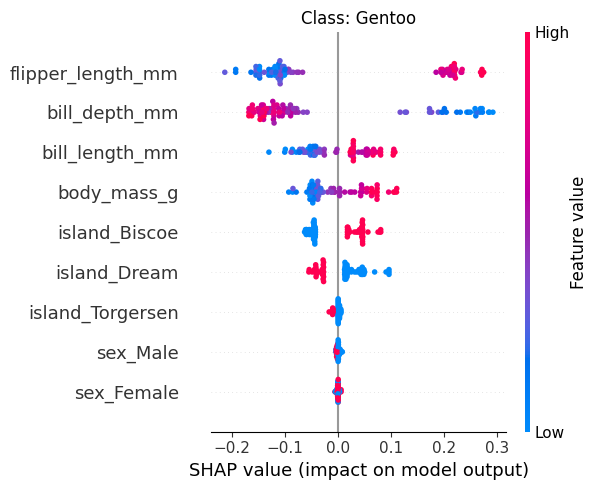

In [44]:
n_classes = len(clf.classes_)

# Plot SHAP directional values for every class
for i, label in enumerate(clf.classes_):
    shap.summary_plot(
        shap_values[:, :, i],
        X_test,
        plot_type="dot",
        show=False
    )
    fig = plt.gcf()
    fig.set_size_inches(6, 5)  # force width, height
    plt.title(f"Class: {label}")

    plt.tight_layout()
    plt.show()

<div style="border: 1px solid rgb(0, 0, 0); background-color:rgb(224, 179, 83); padding: 10px; border-radius: 5px; color: white;">
<b>❓ Question:</b> What do the SHAP dot plots tell us?
</div>

<details>
<summary>💬 Click to show explanation</summary>

<div style="border: 1px solid #007acc; background-color: #e6f2ff; padding: 10px; border-radius: 5px; color: black;">
<b>📈 How to Interpret the SHAP Dot Plot (Per-Class)</b>

The SHAP dot plot shows how individual feature values influence predictions <b>for a specific class</b>.

- Each dot represents one sample’s SHAP value for a feature.
- The <b>horizontal position</b> indicates how much that feature pushed the prediction <b>toward or away from the current class</b>.
- The <b>color</b> shows whether the original feature value was high (pink) or low (blue).

Because we’re working with <b>mutually exclusive classes</b>, a feature pushing toward one class automatically means pushing away from the others.

For example, 
- Short bill length (blue) and short flipper length (blue) have positive SHAP values, meaning they push the model toward predicting **Adelie**.
- Long bill/flipper length (pink) have negative SHAP values, reducing the probability of **Adelie**.

You can use this plot to answer:
- <b>“How does a high or low value of this feature affect predictions for this class?”</b>
- <b>“Do certain features consistently push the model toward or away from a class?”</b>
- <b>“Are there interactions between feature value and effect direction?”</b>
</div>

</details>


## Step 2.3: Dependence plots: More finegrained directional information

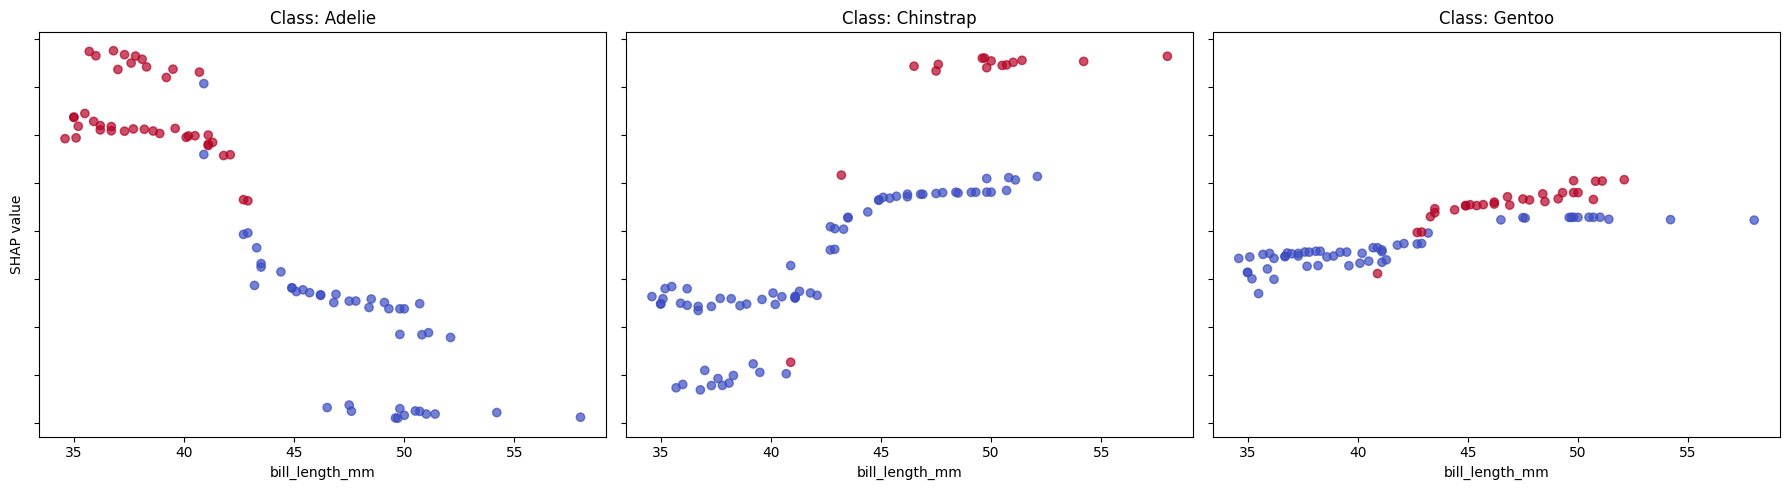

In [83]:
feature = "bill_length_mm"
feature_idx = list(X_test.columns).index(feature)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for class_idx, label in enumerate(clf.classes_):
    ax = axes[class_idx]

    # X: feature values
    x_vals = X_test.iloc[:, feature_idx]
    # Y: SHAP values for that feature and class
    y_vals = shap_values[:, feature_idx, class_idx]
    # Color: 1 if belongs to this class, else 0
    color_vals = (y_test == label).astype(float)

    scatter = ax.scatter(x_vals, y_vals, c=color_vals, cmap="coolwarm", alpha=0.7)
    ax.set_title(f"Class: {label}")
    ax.set_xlabel("bill_length_mm")
    if class_idx == 0:
        ax.set_ylabel("SHAP value")
    else:
        ax.set_yticklabels([])

# fig.colorbar(scatter, ax=axes, location="right", shrink=0.8, label="Belongs to class")
plt.tight_layout()
plt.show()

## Step 2.4: Local instance-specific SHAP values

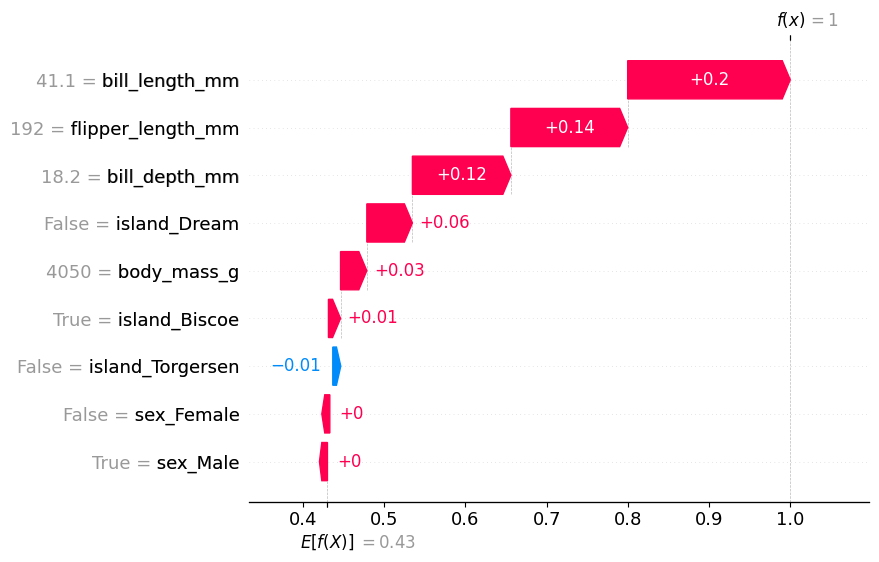

In [51]:
sample_idx = 4
class_idx = 0 # (Adelie)
shap.plots.waterfall(shap.Explanation(values=shap_values[sample_idx, :, class_idx],
                                      base_values=explainer.expected_value[class_idx],
                                      data=X_test.iloc[sample_idx]))


In [53]:
# average feature values
X_test.mean()

bill_length_mm         43.215476
bill_depth_mm          17.207143
flipper_length_mm     200.535714
body_mass_g          4185.416667
island_Biscoe           0.488095
island_Dream            0.321429
island_Torgersen        0.190476
sex_Female              0.535714
sex_Male                0.464286
dtype: float64

<div style="border: 1px solid rgb(0, 0, 0); background-color:rgb(224, 179, 83); padding: 10px; border-radius: 5px; color: white;">
<b>❓ Question:</b> What does the SHAP waterfall plot tell us?
</div>

<details>
<summary>💬 Click to show explanation</summary>

<div style="border: 1px solid #007acc; background-color: #e6f2ff; padding: 10px; border-radius: 5px; color: black;">
<b>📈 Summary:</b>

- Model prediction: Class = Adelie (with confidence = 1)
- Model baseline (E[f(x)]): 0.43 (average probability of Adelie across the data)
- The model moved from 0.43 → 1.00, driven by strong feature contributions

As above, red are low values; blue are high values. 
- Short bill -> strong match for Adelie!
- Short flipper -> again typical for Adelie
- Deep bill -> supports Adelie
- ...
- Not being from Torgersen caused a minor reduction in probability (since Torgersen is linked to Adelie, and this penguin wasn't from there)

**Note**: The SHAP plotting function tends to draw arrows for very small values in the wrong directions. 
</div>

</details>


<div style="border: 1px solid rgb(0, 0, 0); background-color:rgb(224, 179, 83); padding: 10px; border-radius: 5px; color: white;">
<b>🔧 Task:</b> Find a misclassified example and investigate what led to this mistake. Compare with Step 2.2.
</div>

In [49]:
# Find a misclassified example

y_pred = clf.predict(X_test)

# Identify misclassified indices
misclassified = (y_pred != y_test).values  # if y_test is a Series
mis_idx = np.where(misclassified)[0]

# Pick the first misclassified example
i = mis_idx[0]
print(f"Index: {i}, True label: {y_test.iloc[i]}, Predicted: {y_pred[i]}")

Index: 82, True label: Chinstrap, Predicted: Adelie


SHAP Waterfall Plot – Class: Adelie (true class: Chinstrap)


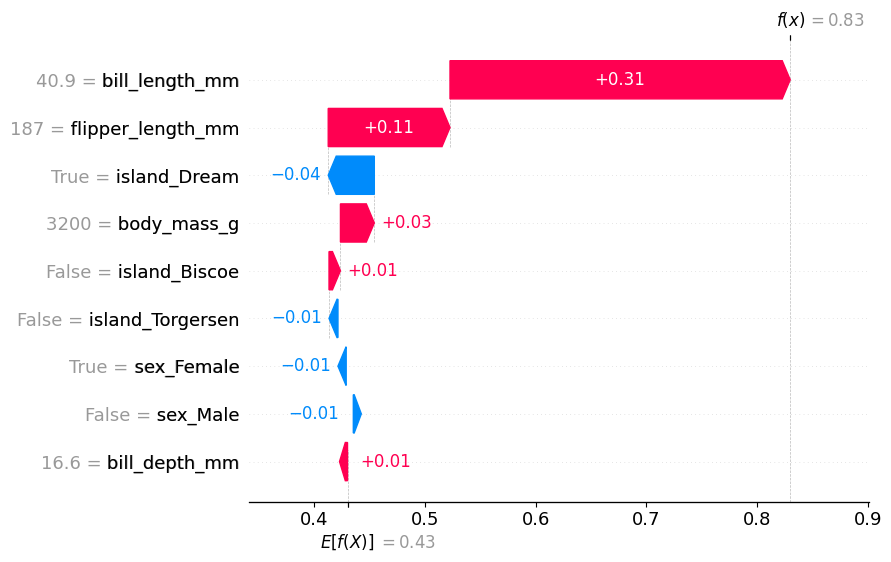

In [60]:
# Investigate what led to this prediction
sample_idx = 82
class_idx = 0 # (Adelie)
print("SHAP Waterfall Plot – Class: Adelie (true class: Chinstrap)")
shap.plots.waterfall(shap.Explanation(values=shap_values[sample_idx, :, class_idx],
                                      base_values=explainer.expected_value[class_idx],
                                      data=X_test.iloc[sample_idx]))


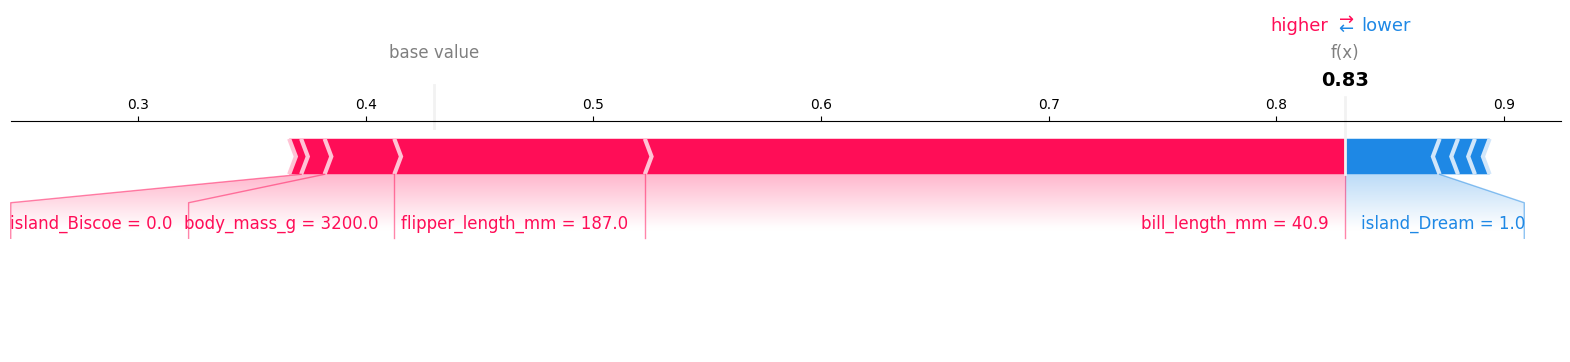

In [63]:
# Force plot version of local SHAP values
shap.force_plot(
    base_value=explainer.expected_value[class_idx],
    shap_values=shap_values[sample_idx, :, class_idx],
    features=X_test.iloc[sample_idx],
    feature_names=X_test.columns,
    matplotlib=True
)